# LBT Blind Offset Calculator

Identify reference stars suitable for doing blind offsets to faint targets on the LBT.  Uses the Gaia star catalog
to provide high-precision astrometric stars.

Code is based in part on the Gaia Archive tutorial (http://archives.esac.esa.int/gaia -> Help -> Tutorials -> Cluster analysis ) 
and adapted to python. The tutorial uses the Gaia TAP+ (astroquery.gaia) module (http://astroquery.readthedocs.io/en/latest/gaia/gaia.html#module-astroquery.gaia)

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import math
import time

# astropy for coordinates and units

from astropy.coordinates import SkyCoord, Distance
from astropy.time import Time

from astropy import units as u
from astropy.units import Quantity

# astroquery for Gaia and TAP+

from astroquery.gaia import Gaia
from astroquery.utils.tap import TapPlus

# Suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore')

## Plot setup

In [18]:
# Plot setup 1:1 aspect ratio

aspect = 1.0

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

figFmt = 'png'
dpi = 600
plotWidth = dpi*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 8
lwidth = 0.5
axisPad = 5
wInches = textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'14'})

# Font and line weight defaults for axes

plt.rcParams.update({'axes.linewidth':lwidth})
plt.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']='%d' % (axisPad)
plt.rcParams['ytick.major.pad']='%d' % (axisPad)
plt.rcParams['axes.labelpad'] = '%d' % (axisPad)

## Load Gaia Tables

Only needs to be done once per notebook session and is good for multiple queries

In [3]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


## Gaia data query

Perform an asynchronous query centered on the nominal field center with a search
radius of `searchRad` degrees.

Search limits:
 * g mag between `gMax` and `gMin` magnitudes
 * no negative or null parallaxes or proper motions
 
A typical query takes 2-3 seconds with a good internet connection depending on server load (YMMV).

In [4]:
# target coordinates

objID = 'WISEA J0736+2430'
objCoords = ['07:36:42.421','+24:30:22.42']

objID = 'WISEA J0743+2606'
objCoords = ['07:43:04.418','+26:05:44.99']

#objID = 'SDSS J1407+2814'
#objCoords = ['14:07:38.083','+28:14:46.14']

#objID = 'SDSS J1347+1630'
#objCoords = ['13:47:00.860','+16:30:15.37']

#objID = 'SDSS J1116+1409'
#objCoords = ['11:16:13.716','+14:09:05.07']

# field radius - usually 6 arcminutes

fieldRad = 6.0 # arcmin

# Gaia magnitude search

minG = 21.0 # faint limit, not many stars though
maxG = 3.0  # bright limit

# SkyCoord object for the target

obj = SkyCoord(objCoords[0],objCoords[1],unit=(u.hourangle, u.deg),frame='icrs')

# Field center coordinates in decimal units

dRA = obj.ra.value
dDec = obj.dec.value

# search radius for the direct gregorian focii is dgfRad arcminutes, convert to decimal degrees

searchRad = math.sqrt(2)*fieldRad/60.0

# execute the Gaia DR3 query

gQuery=f"""
SELECT *
FROM gaiadr3.gaia_source
WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',{dRA},{dDec},{searchRad}))=1
AND phot_g_mean_mag BETWEEN {maxG} and {minG}
AND parallax IS NOT NULL AND parallax>0
AND pmra IS NOT NULL AND abs(pmra)>0
AND pmdec IS NOT NULL AND abs(pmdec)>0
"""

print('Launching Gaia DR3 query...')

t0 = time.time()
job = Gaia.launch_job_async(gQuery)
j = job.get_results()
dt = time.time() - t0

print(f'Retrieved {len(j)} stars (query took {dt:.1f} seconds)')

# process query

#starID = np.array(j['DESIGNATION']) # newer syntax, depends on astropy version

starID = np.array(j['source_id'])
ra = np.array(j['ra'])
dec = np.array(j['dec'])
parallax = np.array(j['parallax'])
pmra = np.array(j['pmra'])
pmdec = np.array(j['pmdec'])
gMag = np.array(j['phot_g_mean_mag'])
rMag = np.array(j['phot_rp_mean_mag'])
bMag = np.array(j['phot_bp_mean_mag'])
epoch = np.array(j['ref_epoch'])

ms = 1.0 + 0.5*(minG-gMag) # magnitude scaling

gaiaEpoch = epoch[0]

numStars = len(j['source_id'])
print(f'magnitude range: {np.min(gMag):.2f} to {np.max(gMag):.2f}')
print(f'Gaia DR3 Epoch {gaiaEpoch:.2f}')

# full coordinate object for the Gaia DR3 stars in the field

stars = SkyCoord(ra=ra*u.deg,
                 dec=dec*u.deg,
                 distance=Distance(parallax=parallax*u.mas,allow_negative=True),
                 pm_ra_cosdec=pmra*u.mas/u.yr,
                 pm_dec=pmdec*u.mas/u.yr,
                 obstime=Time(epoch,format='decimalyear'),
                 frame='icrs')


Launching Gaia DR3 query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 477 stars (query took 3.2 seconds)
magnitude range: 9.13 to 20.87
Gaia DR3 Epoch 2016.00


## Find candidate blind offset reference stars

For each Gaia star found, compute the angular separation in arcseconds on the sky.  Then sort by increasing separation
distance and list the stars from nearest to farthest from the target, giving the magnitude

WISEA J0743+2606 candidate blind offset stars:

StarID                   RA (J2000)    Dec (J2000)   R     sep      dRA.     dDec
Gaia 868872330657743872 07:43:06.543 +26:06:32.71  9.75  55.65"  -28.622  -47.720
Gaia 868871677823060096 07:43:03.087 +26:04:44.18 17.14  63.40"   17.933   60.813
Gaia 868872124499677440 07:43:09.500 +26:06:02.10 17.67  70.57"  -68.464  -17.102
Gaia 868871883981494784 07:42:59.925 +26:05:00.92 17.51  74.87"   60.518   44.076
Gaia 868872128795345536 07:43:10.857 +26:05:26.54 15.10  88.68"  -86.733   18.460
Gaia 868872403673251840 07:43:07.138 +26:07:06.72 13.65  89.56"  -36.637  -81.728
Gaia 868871643463318400 07:43:08.313 +26:04:31.70 15.44  90.13"  -52.469   73.289
Gaia 868872742974972288 07:42:57.596 +26:06:18.72 17.41  97.89"   91.901  -33.718
Gaia 868872124499676928 07:43:12.771 +26:05:59.13 17.82 113.40" -112.521  -14.125
Gaia 868873120932106624 07:42:58.415 +26:07:11.85 16.54 118.67"   80.866  -86.855
Gaia 868871780902265472 07:42:59.232 +26:04:01.61 

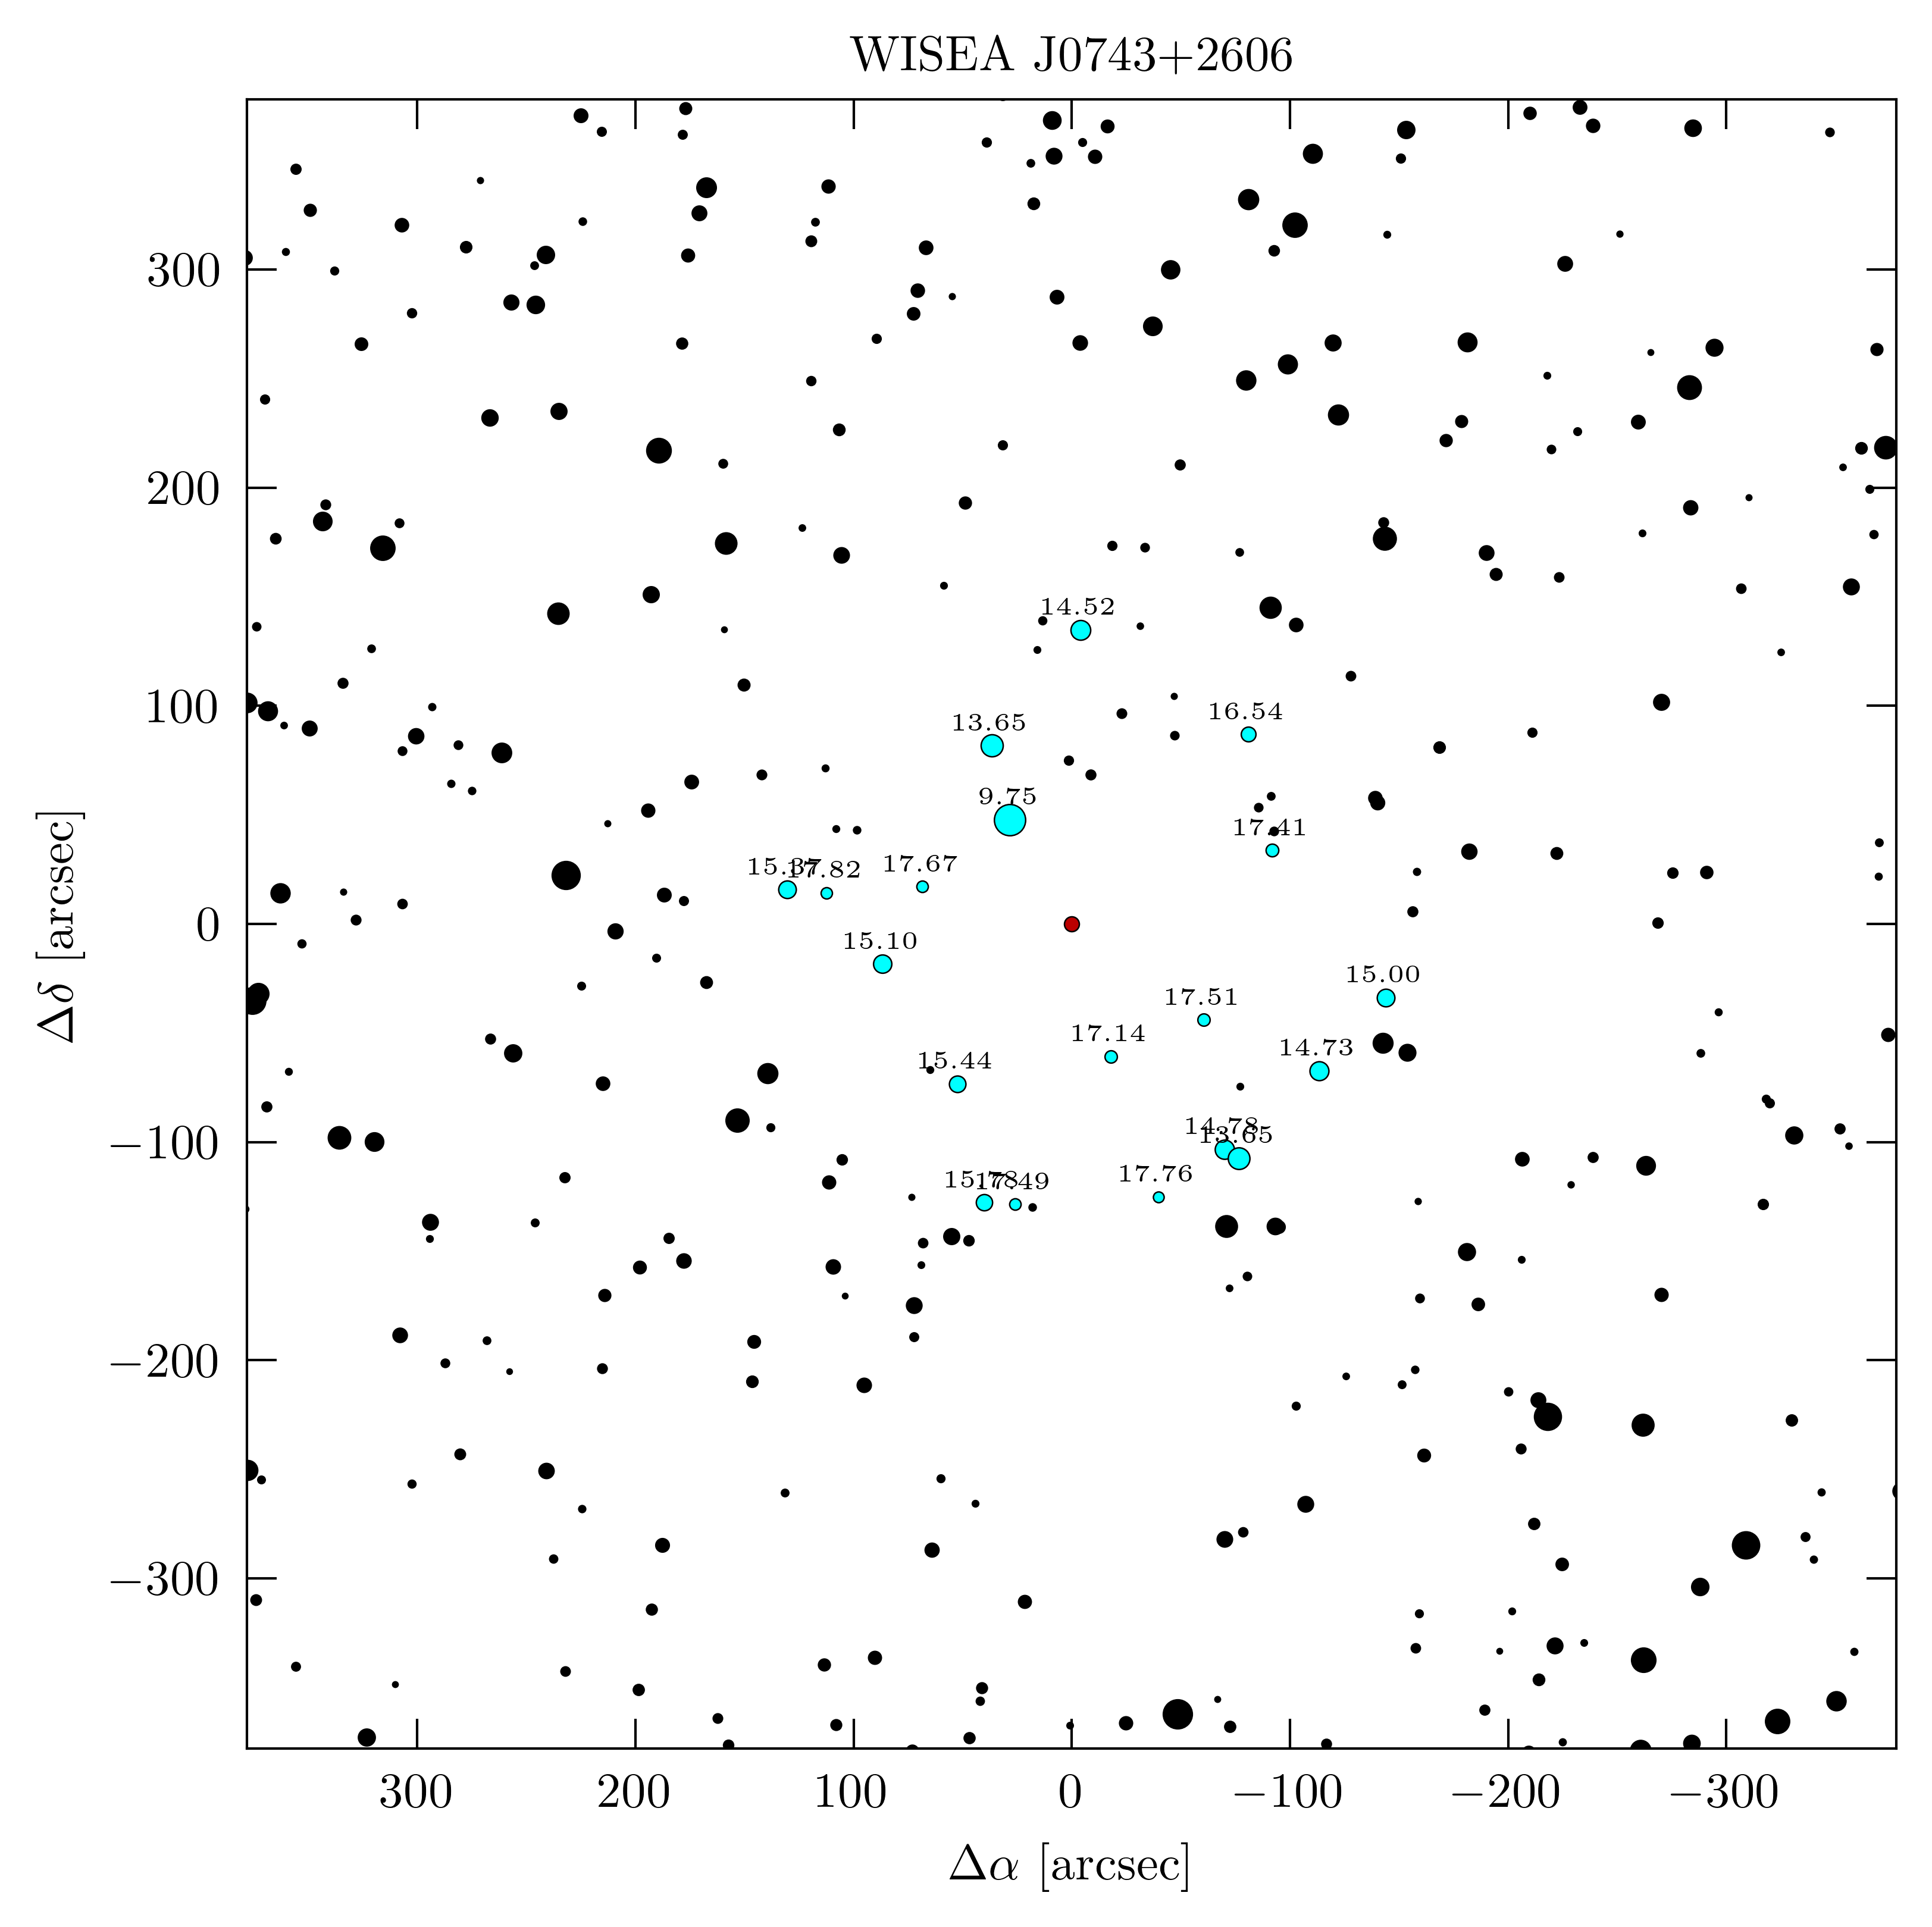

In [27]:
magFaint = 18.0
radMax = 150.0  # arcsec

sepRad = []

for star in stars:
    sep = star.separation(obj)
    sepRad.append(sep.arcsecond)

print(f"{objID} candidate blind offset stars:")
print("\nStarID                   RA (J2000)    Dec (J2000)   R     sep      dRA.     dDec")

for i in np.argsort(sepRad):
    if (rMag[i] <= magFaint and sepRad[i] <= radMax):
        refStar = SkyCoord(stars[i].ra,stars[i].dec,unit=(u.deg,u.deg),frame='icrs')
        dra, ddec = refStar.spherical_offsets_to(obj)
        raStr = stars[i].ra.to_string(unit=u.hour,sep=':',precision=3,pad=True)
        decStr = stars[i].dec.to_string(unit=u.degree,sep=':',precision=2,pad=True,alwayssign=True)
        raOff = dra.to(u.arcsec).value
        decOff = ddec.to(u.arcsec).value
        print(f'Gaia {starID[i]} {raStr} {decStr} {rMag[i]:5.2f} {sepRad[i]:6.2f}\" {raOff:8.3f} {decOff:8.3f}')

# Transform field to (xi,eta) coords in arcseconds centered on the target in the tangent sky plane

skyView = stars.transform_to(obj.skyoffset_frame())
xi = skyView.lon.to(u.arcsec)
eta = skyView.lat.to(u.arcsec)

# Plot the result.  Only label blind offset stars within the magnitude and radius limits

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

ax.set_aspect('equal')

# plot in arcseconds

halfWidth = 1.05*fieldRad*60.0
ax.set_xlim(halfWidth,-halfWidth)
ax.set_ylim(-halfWidth,halfWidth)

# label stars with magnitudes only if they are within 
for i in range(len(xi)):
    xs = xi[i].value
    ys = eta[i].value
    if (rMag[i] <= magFaint and sepRad[i] <= radMax):
        ax.plot(xs,ys,mfc='cyan',mec='black',mew=0.3,alpha=1,marker='o',ms=ms[i],zorder=10)
        ax.text(xs,ys+5,f'{rMag[i]:.2f}',va='bottom',ha='center',fontsize=5,zorder=10)
    else:
        ax.plot(xs,ys,mfc='black',mec='black',mew=0.3,alpha=1,marker='o',ms=ms[i],zorder=10)

# target LOCATION

ax.plot(0,0,'o',mew=0.3,mfc='#bb0000',mec='black',ms=3,zorder=5)

# Label

ax.set_xlabel(r'$\Delta\alpha$ [arcsec]',fontsize=axisFontSize)
ax.set_ylabel(r'$\Delta\delta$ [arcsec]',fontsize=axisFontSize)
ax.set_title(f'{objID}',fontsize=axisFontSize)

plt.show()

#pngFile = f"{objID}_offset.png"
#fig.savefig(pngFile,bbox_inches='tight',facecolor='white')